# Explore 2016 US Bikeshare Data

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, We should start by asking questions we might want to understand about the bike share data. Consider, for example, if we were working for Motivate. What kinds of information would we want to know about in order to make smarter business decisions? If we were users of the bike-share service, what factors might influence how we would want to use the service?

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**: 
- What are the most crowding points across the city?
- Which season has the highest ridership?-Which season has the lowest ridership?

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected in the folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that you'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).

In [96]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [97]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    with open(filename, 'r') as f_in:
        ## Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        ## Use a function on the DictReader object to read the ##
        ## first trip from the data file and store it in a variable.##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip =next(trip_reader)
        ## Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['Washington-CapitalBikeshare-2016.csv',
              'NYC-CitiBike-2016.csv',
              'Chicago-Divvy-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: Washington
OrderedDict([('Duration (ms)', '427387'),
             ('Start date', '3/31/2016 22:57'),
             ('End date', '3/31/2016 23:04'),
             ('Start station number', '31602'),
             ('Start station', 'Park Rd & Holmead Pl NW'),
             ('End station number', '31207'),
             ('End station', 'Georgia Ave and Fairmont St NW'),
             ('Bike number', 'W20842'),
             ('Member Type', 'Registered')])

City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitu

If everything has been filled out correctly, you should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When I set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. We will use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [98]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    The csv module reads in all of the data as strings, including numeric
    values. We will need a function to convert the strings into an appropriate
    numeric type when making your transformations.see https://docs.python.org/3/library/functions.html
    """
    duration = 0
    if city =="Washington":
        duration_str=datum['Duration (ms)']
        duration=float(duration_str)/60000
    elif city=="Chicago":
        duration_str=datum['tripduration']
        duration=float(duration_str)/60
    elif city=="NYC":
        duration_str=datum['tripduration']
        duration=float(duration_str)/60
    
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}
for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [99]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: We should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    if city =="Washington":
        date_str=datum['Start date']
        date_object = datetime.strptime(date_str,'%m/%d/%Y %H:%M')
        month = date_object.month
        hour = date_object.hour
        day_of_week = date_object.strftime('%A')
    elif city=="Chicago":
        date_str=datum['starttime']
        date_object = datetime.strptime(date_str,'%m/%d/%Y %H:%M')
        month = date_object.month
        hour = date_object.hour
        day_of_week = date_object.strftime('%A')
    elif city=="NYC":
        date_str=datum['starttime']
        date_object = datetime.strptime(date_str,'%m/%d/%Y %H:%M:%S')
        month = date_object.month
        hour = date_object.hour
        day_of_week = date_object.strftime('%A')
    
    return (month, hour, day_of_week)


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [100]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    if city=="Chicago" or city=="NYC":
        user_type=datum['usertype'] 
    elif city =="Washington":
        usertype_str=datum['Member Type']
        if usertype_str == "Registered":
            user_type="Subscriber"
        elif usertype_str == "Casual":
            user_type="Customer"
    
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [101]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
     
        for row in trip_reader: 
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}
            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration']=duration_in_mins(row, city) 
            new_point['month']= time_of_trip(row, city)[0]
            new_point['hour']= time_of_trip(row, city)[1]
            new_point['day_of_week']= time_of_trip(row, city)[2]
            new_point['user_type']=type_of_user(row, city)
            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow({'duration': new_point['duration'],'month': new_point['month'], 'hour': new_point['hour'],'day_of_week': new_point['day_of_week'], 'user_type': new_point['user_type']})
            
            

In [102]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': 'Washington-CapitalBikeshare-2016.csv',
                            'out_file': 'Washington-2016-Summary.csv'},
             'Chicago': {'in_file': 'Chicago-Divvy-2016.csv',
                         'out_file': 'Chicago-2016-Summary.csv'},
             'NYC': {'in_file': 'NYC-CitiBike-2016.csv',
                     'out_file': 'NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, We're ready to start exploring the data. In this section we will write some code to compute descriptive statistics from the data. We will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: 
- **NYC** is the city has the highest number of trips
-  **NYC** is the city has the highest proportion of trips made by subscribers
-  **NYC** is the city has the highest proportion of trips made by short-term customers

In [103]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [104]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

data_file = ['Washington-2016-Summary.csv','Chicago-2016-Summary.csv','NYC-2016-Summary.csv']

for file in data_file:
    print(number_of_trips(file))

(51753, 14573, 66326)
(54982, 17149, 72131)
(245896, 30902, 276798)


Now, We will write your own code to continue investigating properties of the data.

**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

In [105]:
## Use this and additional cells to answer Question 4b.                 ##
##                                                                      ##
## HINT: The csv module reads in all of the data as strings, including  ##
## numeric values. You will need a function to convert the strings      ##
## into an appropriate numeric type before you aggregate data.          ##
## TIP: For the Bay Area example, the average trip length is 14 minutes ##
## and 3.5% of trips are longer than 30 minutes.                        ##
"""This function reads in a file with trip data and reports the average length of
    trips in each city"""
def avg_trip_length(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        
        # initialize count&sum variables
        n_more_than_30=0.0
        n_less_than_30=0.0
        total_duration=0.0
        #extracting the data needed
        for row in reader:
            if float(row['duration']) > 30.0 :
                n_more_than_30 += 1.0
            else:
                n_less_than_30 += 1.0
            total_duration +=float(row['duration']) # compute total duration
        n_trips= n_more_than_30 + n_less_than_30 # compute total number of rides
        avg_length= int(total_duration/n_trips) # compute Average Length
        proportion_of_rides_longer_than_30_min= (n_more_than_30/n_trips)
        
        # return Avg_length_of_trip & proportion_of_rides_longer_than_30_min
    return(avg_length,proportion_of_rides_longer_than_30_min)


In [106]:
data_file = ['Washington-2016-Summary.csv','Chicago-2016-Summary.csv','NYC-2016-Summary.csv']
for file in data_file:
    print(avg_trip_length(file))


(18, 0.10838886711093688)
(16, 0.08332062497400562)
(15, 0.07302437156337835)


**Answer**:
- the average trip length for **NYC**: 15 min
- the average trip length for **Washington**: 18 min
- the average trip length for **Chicago**: 16 min
- proportion of rides made in **NYC** longer than 30 minutes is: 7.3%
- proportion of rides made in **Washington** longer than 30 minutes is: 10.8%
- proportion of rides made in **Chicago** longer than 30 minutes is: 8.3%

**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?


In [107]:
## Use this and additional cells to answer Question 4c. If you have    ##
## not done so yet, consider revising some of your previous code to    ##
## make use of functions for reusability.                              ##
##                                                                     ##
## TIP: For the Bay Area example data, you should find the average     ##
## Subscriber trip duration to be 9.5 minutes and the average Customer ##
## trip duration to be 54.6 minutes. Do the other cities have this     ##
## level of difference?                                                ##
"""This function reads in a file with trip data and reports the average length of
    trips in each city"""
def avg_trip_length(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        
        # initialize count&sum variables
        n_customers=0.0
        n_subscribers=0.0
        total_duration=0.0
        total_duration_customers=0.0
        total_duration_subscribers=0.0
        #extracting the data needed
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
                total_duration_subscribers += float(row['duration'])
            else:
                n_customers += 1
            total_duration_customers +=float(row['duration']) # compute total duration
        n_trips= n_subscribers + n_customers # compute total number of rides
        avg_length_subscribers= int(total_duration_subscribers/n_subscribers) # compute Average Length
        avg_length_customers= int(total_duration_customers/n_customers)
        
        # return Avg_length_of_trip_for_subscribers & return Avg_length_of_trip_for_customers
    return( avg_length_subscribers,avg_length_customers)
print(avg_trip_length('NYC-2016-Summary.csv'))

(13, 141)


**Answer**:
- Type of user takes longer rides on average in **NYC**: **Customers**
- the average Subscriber trip duration is **13 minutes** and the average Customer trip duration is **141 minutes**.

<a id='visualizations'></a>
### Visualizations

The last set of values that we computed pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be used here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

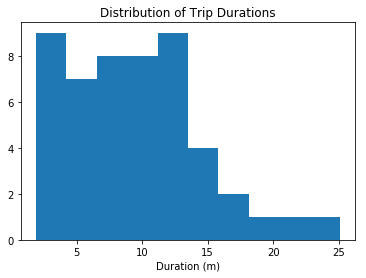

In [108]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

We will now use these functions to create a histogram of the trip times for the city you selected in question 4c. We won't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

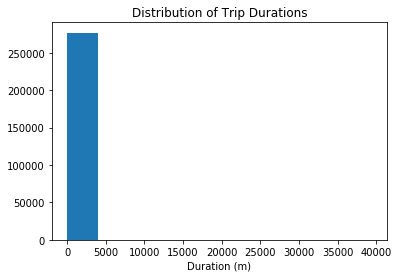

In [109]:
## Use this and additional cells to collect all of the trip times as a list ##
with open('NYC-2016-Summary.csv', 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        
        # initialize tank variable
        NYC_duration=[]
        #extracting the data needed
        for row in reader:
            NYC_duration.append(float(row['duration']))
                
            
## and then use pyplot functions to generate a histogram of trip times.     ##
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook.
%matplotlib inline 

# histogram, data taken from NYC
data = NYC_duration
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

We 're looking at a plot that's completely unexpected. The plot consists of one extremely tall bar on the left, and a whole lot of empty space in the center and right. Taking a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, we will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?


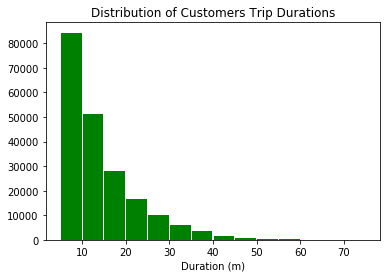

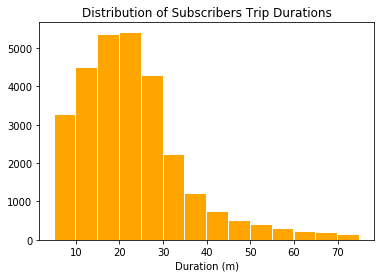

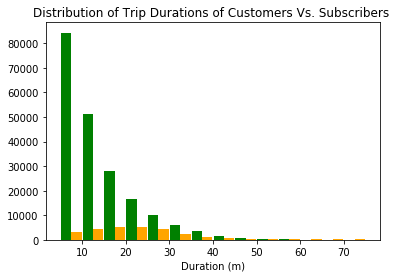

In [110]:
## Use this and additional cells to answer Question 5. ##
with open('NYC-2016-Summary.csv', 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        # initialize tank variables
        duration_customers=[]
        duration_subscribers=[]
        #extracting the data needed
        for row in reader:
            if row['user_type'] == 'Subscriber':
                duration_customers.append(float(row['duration']))
            else:
                duration_subscribers.append(float(row['duration']))
            
## and then use pyplot functions to generate a histogram of trip times.     ##
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook.
%matplotlib inline 

# histogram, data taken from NYC
data_1=duration_customers
data_2=duration_subscribers
plt.hist(data_1, bins=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75],rwidth=0.95,color=['green'])
plt.title('Distribution of Customers Trip Durations')
plt.xlabel('Duration (m)')
plt.show()        
plt.hist(data_2, bins=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75],rwidth=0.95,color=['orange'])
plt.title('Distribution of Subscribers Trip Durations')
plt.xlabel('Duration (m)')
plt.show() 
plt.hist([data_1,data_2], bins=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75],rwidth=0.95,color=['green','orange'])
plt.title('Distribution of Trip Durations of Customers Vs. Subscribers ')
plt.xlabel('Duration (m)')
plt.show()        

**Answer**: 
- For Subsrcibers: - the peak is at **less than 10 min** and I would describe the shape and say that there is a negative relation between no of trips and duration of the trip
- For Customers: - the peak is at **20 to 25 min**  and I would describe the shape and say that there is not a clear negative relative like the other user type as they tends to a longer trip duration

<a id='eda_continued'></a>
## Performing our Own Analysis

So far, we've performed an initial exploration into the data available. We have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, we have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is our turn to continue the exploration in a direction that we choose. 

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

We will work on **NYC City Dataset** and Our questions as follow:
- Which season has the highest ridership?-Which season has the lowest ridership?
- Does the ratio of Subscriber trips to Customer trips change depending on season?
- which Day has the highest ridership?-Which day has the lowest ridership?:
- Does the ratio of Subscriber trips to Customer trips change depending on the weekend?

In [111]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##
"""This function reads in a file with trip data and reports the number of trips in each season"""
def number_of_rides_per_season(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        
        # initialize count variables
        n_autumn=0.0
        n_spring=0.0
        n_winter=0.0
        n_summer=0.0
        
        #extracting the data needed
        for row in reader:
            if float(row['month']) == 12.0 or float(row['month']) == 1.0 or float(row['month']) == 2.0 :
                n_winter += 1.0
            elif float(row['month']) == 3.0 or float(row['month']) == 4.0 or float(row['month']) == 5.0 :
                n_spring += 1.0
            elif float(row['month']) == 6.0 or float(row['month']) == 7.0 or float(row['month']) == 8.0 :
                n_summer += 1.0
            elif float(row['month']) == 9.0 or float(row['month']) == 10.0 or float(row['month']) == 11.0 :
                n_autumn += 1.0
   
        # no_of_rides_per_season
    return(n_autumn,n_spring,n_winter,n_summer)
print(number_of_rides_per_season('NYC-2016-Summary.csv'))

(88366.0, 63028.0, 37536.0, 87868.0)


In [112]:
"""This function reads in a file with trip data and reports the number of trips in each season per user type"""
def number_of_rides_per_season_per_user_type(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        
        # initialize count variables
        n_autumn_subscriber=0.0
        n_spring_subscriber=0.0
        n_winter_subscriber=0.0
        n_summer_subscriber=0.0
        n_autumn_customer=0.0
        n_spring_customer=0.0
        n_winter_customer=0.0
        n_summer_customer=0.0
        
        #extracting the data needed
        for row in reader:
            if row['user_type'] == 'Subscriber':
                
                if float(row['month']) == 12.0 or float(row['month']) == 1.0 or float(row['month']) == 2.0 :
                    n_winter_subscriber += 1.0
                elif float(row['month']) == 3.0 or float(row['month']) == 4.0 or float(row['month']) == 5.0 :
                    n_spring_subscriber += 1.0
                elif float(row['month']) == 6.0 or float(row['month']) == 7.0 or float(row['month']) == 8.0 :
                    n_summer_subscriber += 1.0
                elif float(row['month']) == 9.0 or float(row['month']) == 10.0 or float(row['month']) == 11.0 :
                    n_autumn_subscriber += 1.0
            else:
                if float(row['month']) == 12.0 or float(row['month']) == 1.0 or float(row['month']) == 2.0 :
                    n_winter_customer += 1.0
                elif float(row['month']) == 3.0 or float(row['month']) == 4.0 or float(row['month']) == 5.0 :
                    n_spring_customer += 1.0
                elif float(row['month']) == 6.0 or float(row['month']) == 7.0 or float(row['month']) == 8.0 :
                    n_summer_customer += 1.0
                elif float(row['month']) == 9.0 or float(row['month']) == 10.0 or float(row['month']) == 11.0 :
                    n_autumn_customer += 1.0
            
        # no_of_rides_per_season
    return(n_autumn_subscriber,n_spring_subscriber,n_winter_subscriber,n_summer_subscriber,n_autumn_customer,n_spring_customer,n_winter_customer,n_summer_customer)
print(number_of_rides_per_season_per_user_type('NYC-2016-Summary.csv'))

(78554.0, 55309.0, 35690.0, 76343.0, 9812.0, 7719.0, 1846.0, 11525.0)


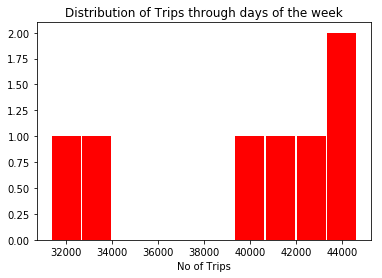

(33353.0, 31352.0, 39340.0, 42405.0, 44629.0, 44330.0, 41389.0)


In [113]:
## and then use pyplot functions to generate a histogram of trip times.     ##
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook.
%matplotlib inline 
"""This function reads in a file with trip data and reports the no of trips through days of the week and plot them"""
def plot_no_of_rides_per_day(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        
        # initialize count variables
        n_saturday=0.0
        n_sunday=0.0
        n_monday=0.0
        n_tuesday=0.0
        n_wednesday=0.0
        n_thursday=0.0
        n_friday=0.0
        
       
        
        #extracting the data needed
        for row in reader:
            if row['day_of_week'] == 'Saturday':
                n_saturday += 1.0
            elif row['day_of_week'] == 'Sunday':
                n_sunday += 1.0
            elif row['day_of_week'] == 'Monday' :
                n_monday += 1.0
            elif row['day_of_week'] == 'Tuesday' :
                n_tuesday += 1.0
            elif row['day_of_week'] == 'Wednesday' :
                n_wednesday += 1.0
            elif row['day_of_week'] == 'Thursday' :
                n_thursday += 1.0
            elif row['day_of_week'] == 'Friday' :
                n_friday += 1.0
    # histogram, data taken from NYC
    plt.hist([n_saturday, n_sunday,n_monday, n_tuesday,n_wednesday,n_thursday, n_friday], rwidth=0.95,color=['red'])
    plt.title('Distribution of Trips through days of the week')
    plt.xlabel('No of Trips')
    plt.show()          
    return(n_saturday,n_sunday,n_monday,n_tuesday,n_wednesday,n_thursday,n_friday)     
print(plot_no_of_rides_per_day('NYC-2016-Summary.csv'))



      
       

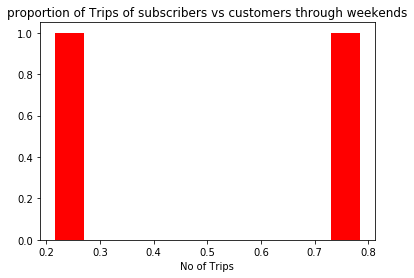

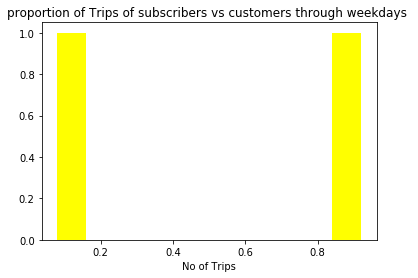

(0.9227992591752655, 0.07720074082473448, 0.7850989522700815, 0.2149010477299185)


In [114]:
## and then use pyplot functions to generate a histogram.    ##
# load library
import matplotlib.pyplot as plt
# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook.
%matplotlib inline 

def no_of_rides__proportion_in_weekdays_and_weekends_per_usertype(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader =csv.DictReader(f_in)
        
        # initialize count variables
   
        n_weekend_subscriber = 0.0
        n_weekday_subscriber = 0.0
        n_weekend_customer = 0.0
        n_weekday_customer = 0.0
        n_weekday = 0.0
        n_weekend = 0.0

       
        
        #extracting the data needed
        for row in reader:
            if row['user_type'] == 'Subscriber':
                if row['day_of_week'] == 'Saturday' or row['day_of_week'] == 'Sunday':
                    n_weekend_subscriber += 1.0
                else:
                    n_weekday_subscriber += 1.0
            elif row['user_type'] == 'Customer':
                if row['day_of_week'] == 'Saturday' or row['day_of_week'] == 'Sunday':
                    n_weekend_customer += 1.0
                else:
                    n_weekday_customer += 1.0
        n_weekday = n_weekday_subscriber + n_weekday_customer
        n_weekend = n_weekend_subscriber + n_weekend_customer
         
        avg_subscriber_rides_weekday=(n_weekday_subscriber/n_weekday)
        avg_subscriber_rides_weekend= (n_weekend_subscriber/n_weekend)
        avg_customer_rides_weekday= ( n_weekday_customer/n_weekday)
        avg_customer_rides_weekend= (n_weekend_customer/n_weekend)
    plt.hist([avg_subscriber_rides_weekend,avg_customer_rides_weekend], rwidth=0.95,color=['red'])
    plt.title('proportion of Trips of subscribers vs customers through weekends')
    plt.xlabel('No of Trips')
    plt.show()
    plt.hist([avg_subscriber_rides_weekday, avg_customer_rides_weekday], rwidth=0.95,color=['yellow'])
    plt.title('proportion of Trips of subscribers vs customers through weekdays ')
    plt.xlabel('No of Trips')
    plt.show()  
    return(avg_subscriber_rides_weekday, avg_customer_rides_weekday, avg_subscriber_rides_weekend,avg_customer_rides_weekend)     
print(no_of_rides__proportion_in_weekdays_and_weekends_per_usertype('NYC-2016-Summary.csv'))


**Answer**:
In **NYC City**
- Which season has the highest ridership?-Which season has the lowest ridership?: - **Autumn** season has the highest ridership while **Winter** season has the lowest ridership
- Does the ratio of Subscriber trips to Customer trips change depending on season?: -Yes, as the top season for **subscribers** is **autumn** while the top season for **customers** is **summer**
- which Day has the highest ridership?-Which day has the lowest ridership?:- **Wednesday** has the highest ridership while **Sunday** season has the lowest ridership
- Does the ratio of Subscriber trips to Customer trips change depending on the weekend?: yes, **Customer** ratio rises significantly on **weekends** to 3 times its ratio through weekdays eventhough **subscriber** ratio is more than customer ratio in both cases.

<a id='conclusions'></a>
## Conclusions

Normally, at this point in the data analysis process, we might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: Football field , we can get to know the real statistics of each player and how to improve his abilities to the best form and even build up predictions for the status of players of  the competing team.